In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
%matplotlib inline

read the data

In [47]:
transaction = pd.read_csv("../data/train_transactions.csv",index_col = 0)
fraud = pd.read_csv("../data/train_fraudsters.csv",index_col = 0)
users = pd.read_csv("../data/train_users.csv",index_col = 0)
rate = pd.read_csv("../data/fx_rates.csv")
transaction.CREATED_DATE = pd.to_datetime(transaction.CREATED_DATE)
transaction.Fraud = transaction.Fraud.apply(lambda x: 0 if x== "0" else 1)

### Base Line Model

Randomly Guess if it's Fraud or not
<BR>
Simple Logistic Model base on transaction Amount

In [92]:
Guess_Fraud =  transaction.Fraud.apply(lambda x: 1 if np.random.uniform(0,1)>0.5 else 0)

In [93]:
print(classification_report(transaction.Fraud,Guess_Fraud))

              precision    recall  f1-score   support

           0       0.98      0.50      0.66    674108
           1       0.02      0.51      0.04     14543

    accuracy                           0.50    688651
   macro avg       0.50      0.51      0.35    688651
weighted avg       0.96      0.50      0.65    688651



With random guess, there is a 2% chance of being correct on predicting Fraud

In [195]:
X = transaction.AMOUNT
y = transaction.Fraud
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20,stratify = y)

In [198]:
log =  LogisticRegression()
log.fit(np.array(X_train).reshape(-1,1),y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [199]:
print(classification_report(y_test,log.predict(np.array(X_test).reshape(-1,1))))

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99    202233
           1       0.00      0.00      0.00      4363

    accuracy                           0.98    206596
   macro avg       0.49      0.50      0.49    206596
weighted avg       0.96      0.98      0.97    206596



With a Logistic model, it pretty much guess every as not fraud

Build a Random Forest and Gradient Boosting Model base on some features

In [203]:
X = transaction[["AMOUNT","TYPE","SOURCE"]]
X = pd.concat([X.AMOUNT,pd.get_dummies(X.drop("AMOUNT",axis=1))],axis =1)
y = transaction.Fraud

using 3 features to build Random Forest and Gradient Boost

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20,stratify = y)

In [208]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
print(classification_report(y_test,rf.predict(X_test)))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99    202233
           1       0.49      0.13      0.21      4363

    accuracy                           0.98    206596
   macro avg       0.74      0.56      0.60    206596
weighted avg       0.97      0.98      0.97    206596



In [209]:
gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)
print(classification_report(y_test,gb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    202233
           1       0.59      0.07      0.12      4363

    accuracy                           0.98    206596
   macro avg       0.79      0.53      0.56    206596
weighted avg       0.97      0.98      0.97    206596



Both the random forest model and gradient decent are not promising as well, with really low recall

### Feature Engineering

Base on the EDA, there is a lot of outliers

And there is variable in the features can really distinguish between Fraud and not Fraud

In [48]:
# transaction.Fraud = data.Fraud.apply(lambda x: 0 if x== "0" else 1)
q = transaction.AMOUNT.quantile(0.99)
transaction = transaction[transaction["AMOUNT"] < q]
transaction.AMOUNT = transaction.AMOUNT/100
transaction.drop(["STATE"],axis =1,inplace= True)

In [49]:
users.PHONE_COUNTRY = users.PHONE_COUNTRY.apply(lambda x: x.split("||"))
users["phone"] = users.PHONE_COUNTRY.apply(lambda x: len(x))
users = pd.merge(users,fraud,how="left",left_on="ID",right_on = "user_id")
users["is_fraud"] = users.user_id.apply(lambda x:0 if x is np.nan  else 1)

In [50]:
#Try to conver all amount to GBP
transaction = pd.merge(transaction,rate,how ="left",left_on="CURRENCY",right_on="Currency")
transaction.AMOUNT = transaction.AMOUNT/ transaction.Rate

In [51]:
transaction["is_atm"] =transaction.MERCHANT_CATEGORY.apply(lambda x: 1 if x=="atm" else 0)
transaction["is_GBR"] = transaction.MERCHANT_COUNTRY.apply(lambda x: 1 if x=="GBR" else 0)
transaction["is_USA"] = transaction.MERCHANT_COUNTRY.apply(lambda x: 1 if x=="USA" else 0)
transaction["is_manu"] = transaction.ENTRY_METHOD.apply(lambda x: 1 if x=="manu" else 0)
transaction["is_bank_transfer"] = transaction.TYPE.apply(lambda x: 1 if x=="BANK_TRANSFER" else 0)
transaction["is_minos"] = transaction.SOURCE.apply(lambda x: 1 if x=="MINOS" else 0)
users["is_kyc_none"] = users.KYC.apply(lambda x: 1 if x=="NONE" else 0)
users["is_4"] =users.phone.apply(lambda x: 1 if x>=4 else 0)

In [52]:
need1 = transaction[["AMOUNT","USER_ID","is_atm","is_GBR","is_manu","is_bank_transfer","is_minos","Fraud","is_USA"]]
need2 = users[["ID","phone","is_kyc_none","is_4"]]

Create final data frame

In [9]:
final_data = pd.merge(need1,need2,how = "left",left_on="USER_ID",right_on ="ID")


In [377]:
final_data.columns

Index(['AMOUNT', 'USER_ID', 'is_atm', 'is_GBR', 'is_manu', 'is_bank_transfer',
       'is_minos', 'Fraud', 'is_USA', 'ID', 'phone', 'is_kyc_none', 'is_4'],
      dtype='object')

Just want to keep unique user id and get the median value for each users

In [393]:
final_data = final_data.groupby("USER_ID").median().reset_index()

In [394]:
X = final_data.drop(["USER_ID","Fraud"],axis =1)
y = final_data["Fraud"]

In [395]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=20,stratify = y)

In [396]:
rf = RandomForestClassifier(1000)
rf.fit(X_train,y_train)
print(classification_report(y_test,rf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      3859
         1.0       0.64      0.40      0.49       150

    accuracy                           0.97      4009
   macro avg       0.81      0.70      0.74      4009
weighted avg       0.96      0.97      0.97      4009



In [397]:
gb = GradientBoostingClassifier(learning_rate=0.01,n_estimators=1000)
gb.fit(X_train,y_train)
print(classification_report(y_test,gb.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      3859
         1.0       0.86      0.42      0.57       150

    accuracy                           0.98      4009
   macro avg       0.92      0.71      0.78      4009
weighted avg       0.97      0.98      0.97      4009



really huge improvement from the previous models. Gradient Boost Seem to be the Best as well
<BR>
Recall is at 52%
<BR>
Precision is at 79%

<BarContainer object of 10 artists>

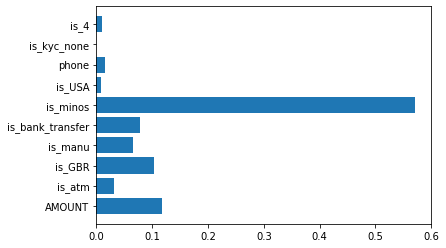

In [386]:
plt.barh(X.columns,gb.feature_importances_)


from the feature importance graph, seems like some of the features is not that helpful

In [438]:
reduce_feature = final_data.drop(["USER_ID","is_4","is_kyc_none","is_USA"],axis =1)

In [114]:
X = reduce_feature.drop(["Fraud"],axis =1)
y = reduce_feature["Fraud"]

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=20,stratify = y)

In [116]:
gb = GradientBoostingClassifier(learning_rate=0.01,n_estimators=1000)
gb.fit(X_train,y_train)
print(classification_report(y_test,gb.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      3859
         1.0       0.89      0.39      0.54       150

    accuracy                           0.98      4009
   macro avg       0.93      0.69      0.76      4009
weighted avg       0.97      0.98      0.97      4009



reducing features incease the precisoin but lower the recall

## Try using mean after groupby

In [28]:
final_data = pd.merge(need1,need2,how = "left",left_on="USER_ID",right_on ="ID")
final_data = final_data.groupby("USER_ID").mean().reset_index()

In [29]:
X = final_data.drop(["USER_ID","Fraud"],axis =1)
y = final_data["Fraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=20,stratify = y)

In [451]:
gb = GradientBoostingClassifier(learning_rate=0.01,n_estimators=1000)
gb.fit(X_train,y_train)
print(classification_report(y_test,gb.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3859
         1.0       0.79      0.69      0.74       150

    accuracy                           0.98      4009
   macro avg       0.89      0.84      0.86      4009
weighted avg       0.98      0.98      0.98      4009



On Reduce Features

In [30]:
reduce_feature = final_data.drop(["is_4","is_kyc_none","is_USA","USER_ID"],axis =1)
X = reduce_feature.drop(["Fraud"],axis =1)
y = reduce_feature["Fraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=20,stratify = y)

In [31]:
gb = GradientBoostingClassifier(learning_rate=0.01,n_estimators=1000)
gb.fit(X_train,y_train)
print(classification_report(y_test,gb.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3859
         1.0       0.80      0.69      0.74       150

    accuracy                           0.98      4009
   macro avg       0.89      0.84      0.87      4009
weighted avg       0.98      0.98      0.98      4009



## Try smote and undersampling

In [768]:
sm = SMOTE(ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [769]:
gb = GradientBoostingClassifier(learning_rate=0.1,n_estimators=700)
gb.fit(X_train_res,y_train_res)
print(classification_report(y_test,gb.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      3859
         1.0       0.50      0.78      0.61       150

    accuracy                           0.96      4009
   macro avg       0.75      0.87      0.79      4009
weighted avg       0.97      0.96      0.97      4009



In [325]:
print(classification_report(y_train_res,gb.predict(X_train_res)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5402
         1.0       1.00      1.00      1.00      5402

    accuracy                           1.00     10804
   macro avg       1.00      1.00      1.00     10804
weighted avg       1.00      1.00      1.00     10804



Down sampling

In [327]:
ds = RandomUnderSampler(random_state=12, ratio = 1.0)
X_train_res, y_train_res = ds.fit_sample(X_train, y_train)

In [330]:
gb = GradientBoostingClassifier(learning_rate=0.1,n_estimators=700)
gb.fit(X_train_res,y_train_res)
print(classification_report(y_test,gb.predict(X_test)))

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95      2316
         1.0       0.27      0.91      0.41        90

    accuracy                           0.90      2406
   macro avg       0.63      0.91      0.68      2406
weighted avg       0.97      0.90      0.93      2406



In [331]:
print(classification_report(y_train_res,gb.predict(X_train_res)))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       209
         1.0       1.00      0.99      1.00       209

    accuracy                           1.00       418
   macro avg       1.00      1.00      1.00       418
weighted avg       1.00      1.00      1.00       418



looks like it's overfitting when using both over sampling and down sampling, but the difference is way too much

XGBOOST

In [333]:
import xgboost as xgb

In [334]:
dtrain = xgb.DMatrix(X_train.values,y_train.values)
dtest = xgb.DMatrix(X_test.values,y_test.values)

In [335]:
param = {'max_depth': 6, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'rmse'

In [336]:
param['eval_metric'] = ['rmse', 'ams@0']

In [337]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [338]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-rmse:0.176718	eval-ams@0:8.38399	train-rmse:0.162292	train-ams@0:17.7234
[1]	eval-rmse:0.141213	eval-ams@0:8.51862	train-rmse:0.111838	train-ams@0:20.6388
[2]	eval-rmse:0.136097	eval-ams@0:8.64731	train-rmse:0.096374	train-ams@0:22.789
[3]	eval-rmse:0.135661	eval-ams@0:8.91555	train-rmse:0.088294	train-ams@0:23.883
[4]	eval-rmse:0.136409	eval-ams@0:8.8646	train-rmse:0.082742	train-ams@0:24.3841
[5]	eval-rmse:0.13872	eval-ams@0:8.49779	train-rmse:0.078551	train-ams@0:25.2686
[6]	eval-rmse:0.139624	eval-ams@0:8.38399	train-rmse:0.071946	train-ams@0:26.3085
[7]	eval-rmse:0.14025	eval-ams@0:8.56149	train-rmse:0.067274	train-ams@0:26.7186
[8]	eval-rmse:0.142527	eval-ams@0:8.22142	train-rmse:0.063588	train-ams@0:27.6296
[9]	eval-rmse:0.142595	eval-ams@0:8.18549	train-rmse:0.060074	train-ams@0:28.3805


In [340]:
df_bst = pd.DataFrame()
df_bst["bst"] = bst.predict(dtest)
df_bst["predict"] =df_bst["bst"].apply(lambda x : 1 if x>0.5 else 0)

In [341]:
print(classification_report(y_test,df_bst["predict"] ))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2316
         1.0       0.67      0.61      0.64        90

    accuracy                           0.97      2406
   macro avg       0.83      0.80      0.81      2406
weighted avg       0.97      0.97      0.97      2406



In [360]:
xgb_model = xgb.XGBClassifier(
 learning_rate =0.1,reg_alpha=0.2,n_estimators=700)

In [361]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=700, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [362]:
print(classification_report(y_test,xgb_model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2316
         1.0       0.78      0.64      0.71        90

    accuracy                           0.98      2406
   macro avg       0.89      0.82      0.85      2406
weighted avg       0.98      0.98      0.98      2406



It seems groupby mean is the best, perform a grid search on the hyper parameter

In [12]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.6,0.7,0.8],
    "n_estimators":[100,500,700,1000]
    }

In [18]:
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1,verbose=2)
clf.fit(X_train,y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 16.5min


KeyboardInterrupt: 

Create Data for dashboard

In [251]:
dashboard = pd.merge(transaction,need2, how = "left",left_on="USER_ID", right_on="ID")

In [510]:
mask = list(X.columns)

In [513]:
dashboard["Fraud Probabiliy"] = gb.predict_proba(dashboard[mask])[:,1]

In [396]:
gb.predict_proba(X)[:,1]

array([0.00245309, 0.00120751, 0.00322216, ..., 0.00653926, 0.00118222,
       0.00224197])

In [253]:
dashboard.to_csv("../dashboard/data.csv")

In [340]:
dashboard2 = pd.concat([X_test,y_test],axis=1)

In [341]:
dashboard2["Fraud Probability"] = gb.predict_proba(X_test.drop(["USER_ID"],axis =1))[:,1]

In the Predict Probability of being Fraud
At 95% Percentile
The probability is 14% or higher.
AT 96% Percentile
The probability is 26% or higher.
AT 97% Percentile
The Probability is 50% or higher.

Translate the percentile to action.
Only 5% or less will receive alert
4% or less will be Lock
3% or less will be both.

In [342]:
def action(x):
    if x>=0.15 and x<0.25:
        return "Alert"
    if x>=0.25 and x<0.5:
        return "Lock"
    if x>=0.5:
        return "Alert and Lock"
    else:
        return "No Action"

In [343]:
dashboard2["Action"]  = dashboard2["Fraud Probability"].apply(lambda x: action(x))

In [347]:
dashboard2.to_csv("../data/dashboard2.csv",index= False)

In [345]:
print(classification_report(y_test,gb.predict(X_test.drop(["USER_ID"],axis =1))))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3859
         1.0       0.80      0.69      0.74       150

    accuracy                           0.98      4009
   macro avg       0.89      0.84      0.87      4009
weighted avg       0.98      0.98      0.98      4009



Business Case

In [53]:
transaction[transaction.Fraud == 1].describe().round(2)

,AMOUNT,Fraud,Rate,is_atm,is_GBR,is_USA,is_manu,is_bank_transfer,is_minos
count,14052.00,14052.0,14052.00,14052.00,14052.00,14052.00,14052.00,14052.00,14052.00
mean,151.80,1.0,2.23,0.06,0.47,0.02,0.25,0.08,0.18
std,390.23,0.0,86.14,0.25,0.50,0.13,0.43,0.27,0.39
min,0.00,1.0,0.04,0.00,0.00,0.00,0.00,0.00,0.00
25%,5.00,1.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,20.00,1.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,150.00,1.0,1.00,0.00,1.00,0.00,0.00,0.00,0.00
max,12925.58,1.0,5896.96,1.00,1.00,1.00,1.00,1.00,1.00


In [54]:
transaction[transaction.Fraud == 0].describe().round(2)

,AMOUNT,Fraud,Rate,is_atm,is_GBR,is_USA,is_manu,is_bank_transfer,is_minos
count,667682.00,667682.0,667682.00,667682.00,667682.00,667682.00,667682.00,667682.00,667682.00
mean,214.73,0.0,2.21,0.01,0.21,0.07,0.13,0.02,0.01
std,3056.72,0.0,87.78,0.12,0.41,0.25,0.34,0.14,0.11
min,0.00,0.0,0.01,0.00,0.00,0.00,0.00,0.00,0.00
25%,5.00,0.0,0.90,0.00,0.00,0.00,0.00,0.00,0.00
50%,15.47,0.0,0.90,0.00,0.00,0.00,0.00,0.00,0.00
75%,55.64,0.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00
max,176717.31,0.0,5896.96,1.00,1.00,1.00,1.00,1.00,1.00


On average, the mean Fraud Transaction Amount is 132, and 62 for not fraud.
<BR>
Assuming loss for Fraud is 132, and 20% of the loss is not recoverable, which is about 26.5
<BR>
Revenue from non fraud is 2% of 62, which is 1.24
    
Every False Positive(Predict Fraud but not Fraud) case, loss is # of FP * 1.24 <BR>
Every False Negative(Predict not Fraud but Fraud), loss is # of FN * 26.5.<BR>
Every True Negative(Predict not Fraud and not Fraud), gain is # of TN *1.24<BR>
Every True Postive(Predict Fraud and Fraud), gain is 0



In [233]:
print("At 50% Threshhold, confusion matrix is going to be:")
print(confusion_matrix(y_test,gb.predict(X_test)))

At 50% Threshhold, confusion matrix is going to be:
[[3833   26]
 [  46  104]]


In [59]:
def overall_revenue(FN,FP,TN):
    """
    Return revenue by giving number of False Negative and False Postive value
    Input: int
    """
    return -26.5*FN-1.24*FP+1.24*TN


In [60]:
predict_df =pd.DataFrame()
predict_df["Prediction"] = gb.predict_proba(X_test)[:,1]

In [61]:
threshold_lst = np.linspace(0,1,101)


In [62]:
revenue_lst =[]
for threshold in threshold_lst:
    prediction = predict_df["Prediction"] > threshold
    tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
    revenue_lst.append(overall_revenue(fn,fp,tn))

In [66]:
ymax = max(revenue_lst)
xpos = revenue_lst.index(ymax)
xmax = threshold_lst[xpos]

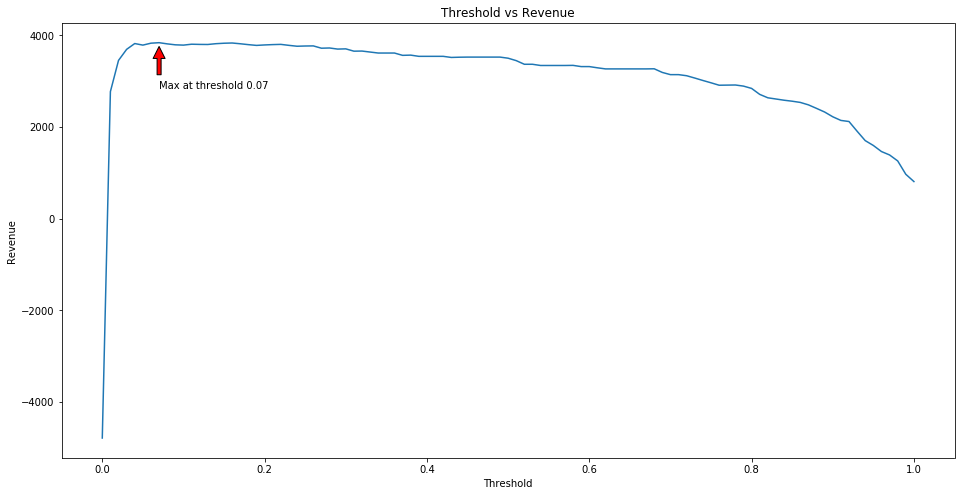

In [87]:
plt.figure(figsize=(16,8))
plt.plot(threshold_lst,revenue_lst)
plt.title("Threshold vs Revenue")
plt.xlabel("Threshold")
plt.ylabel("Revenue")
plt.annotate('Max at threshold {}'.format(xmax), xy=(xmax, ymax), xytext=(xmax, ymax-1000),
            arrowprops=dict(facecolor='red', shrink=0.1),
            )
plt.savefig("../img/threshold.png")



In [86]:
def highest_revenue(revenue_lst):
    """
    Output: the threshold of highest revenue
    Input: list contain revenue at different threshold
    """
    threshold_lst[np.argmax(revenue_lst)]

In [71]:
threshold_lst[np.argmax(revenue_lst)]

0.07

In [248]:
print(classification_report(y_test,predict_df["Prediction"] > 0.07))
print(confusion_matrix(y_test,predict_df["Prediction"] > 0.07))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98      3859
         1.0       0.47      0.85      0.60       150

    accuracy                           0.96      4009
   macro avg       0.73      0.91      0.79      4009
weighted avg       0.97      0.96      0.96      4009

[[3713  146]
 [  22  128]]


Revenue Max when threshold is at 7%, recall is 85% and precision 47%.<BR>
Using 7% threshold on the test dataset, the model will miss 22 fraud, and classify 146 person that is not fraud to be fraud.<BR>
True Positive Rate will be 128/(128+22) = 85.33% <BR>
False Positive Rate will be 146/(146+3713) = 3.78%<BR>
Revenue = -26.5 * 22 - 1.24 * 146+ 1.24 * 3713 = 3840.8

Plot the ROC Curve

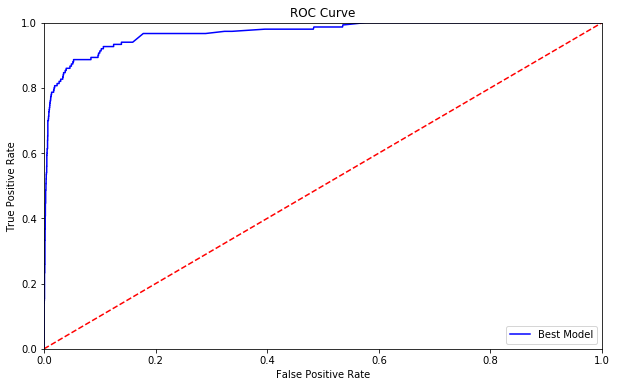

In [249]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = gb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'Best Model')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [410]:
transaction[transaction.Fraud ==0].groupby("USER_ID").sum().mean().round(2)

AMOUNT    5364.32
Fraud        0.00
dtype: float64

In [411]:
transaction[transaction.Fraud ==1].groupby("USER_ID").sum().mean().round(2)

AMOUNT    6202.62
Fraud       47.00
dtype: float64

In [35]:
a= pd.DataFrame(gb.predict_proba(X_test),columns=["Not Fraud","Fraud"])

(array([3.703e+03, 6.900e+01, 4.000e+01, 2.000e+01, 1.400e+01, 1.000e+01,
        1.000e+01, 6.000e+00, 5.000e+00, 2.000e+00, 6.000e+00, 2.000e+00,
        3.000e+00, 8.000e+00, 1.000e+01, 9.000e+00, 1.400e+01, 1.500e+01,
        2.900e+01, 3.400e+01]),
 array([6.83534378e-04, 5.04822161e-02, 1.00280898e-01, 1.50079580e-01,
        1.99878261e-01, 2.49676943e-01, 2.99475625e-01, 3.49274307e-01,
        3.99072989e-01, 4.48871670e-01, 4.98670352e-01, 5.48469034e-01,
        5.98267716e-01, 6.48066397e-01, 6.97865079e-01, 7.47663761e-01,
        7.97462443e-01, 8.47261124e-01, 8.97059806e-01, 9.46858488e-01,
        9.96657170e-01]),
 <a list of 20 Patch objects>)

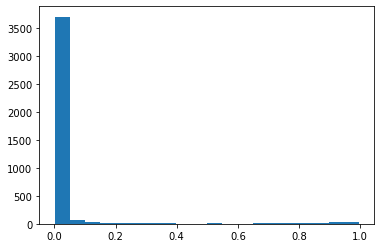

In [37]:
plt.hist(a.Fraud,bins =20)

In [40]:
np.percentile(a.Fraud,96)

0.266642317587601

In [43]:
transaction.TYPE.value_counts()

CARD_PAYMENT     434625
TOPUP            129579
P2P               56035
ATM               46787
BANK_TRANSFER     14708
Name: TYPE, dtype: int64

In [45]:
transaction.USER_ID.nunique()

8017